<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/ASTRONOMY_AI_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lightkurve -q

In [10]:
import lightkurve as lk
search_result = lk.search_lightcurve('TIC 164173105', mission='tess')
print(search_result)

SearchResult containing 9 data products.

 #     mission     year   author  exptime target_name distance
                                     s                 arcsec 
--- -------------- ---- --------- ------- ----------- --------
  0 TESS Sector 16 2019      SPOC     120   164173105      0.0
  1 TESS Sector 56 2022      SPOC     120   164173105      0.0
  2 TESS Sector 83 2024      SPOC     120   164173105      0.0
  3 TESS Sector 16 2019 TESS-SPOC    1800   164173105      0.0
  4 TESS Sector 56 2022 TESS-SPOC     200   164173105      0.0
  5 TESS Sector 16 2019       QLP    1800   164173105      0.0
  6 TESS Sector 56 2022       QLP     200   164173105      0.0
  7 TESS Sector 83 2024       QLP     200   164173105      0.0
  8 TESS Sector 16 2019     CDIPS    1800   164173105      0.0


Attempting to configure Gemini client for **gemini-3-pro-preview**.
Gemini client configured successfully using userdata.

--- 🤖 Agent Executing TESS Data Acquisition for TIC 164173105 ---
Action 1/3: Attempting to download TESS light curve from MAST...
Observation 1: TESS data (Sector 16) successfully retrieved and REAL features extracted.
Agent proceeding with Pulsation Features (REAL TESS Data): [ 1.7079  0.0373 13.    ]

--- 🧠 Action 2/3: Generating Comparison Dataset for ML Clustering ---

--- 📊 Action 3/3: Executing K-Means Clustering (ML Technique) ---
Observation 3: K-Means Clustering complete (k=4).
TIC 164173105 was grouped into Cluster 0.

Results Summary (First 5 data points):
                       Star  Cluster
0  TIC 164173105 (Analyzed)        0
1              HBS Baseline        2
2                      DS_0        0
3                      DS_1        3
4                      DS_2        3

--- 🤖 Action 4/3: Executing LLM Classification (Gemini) ---

LLM Classification

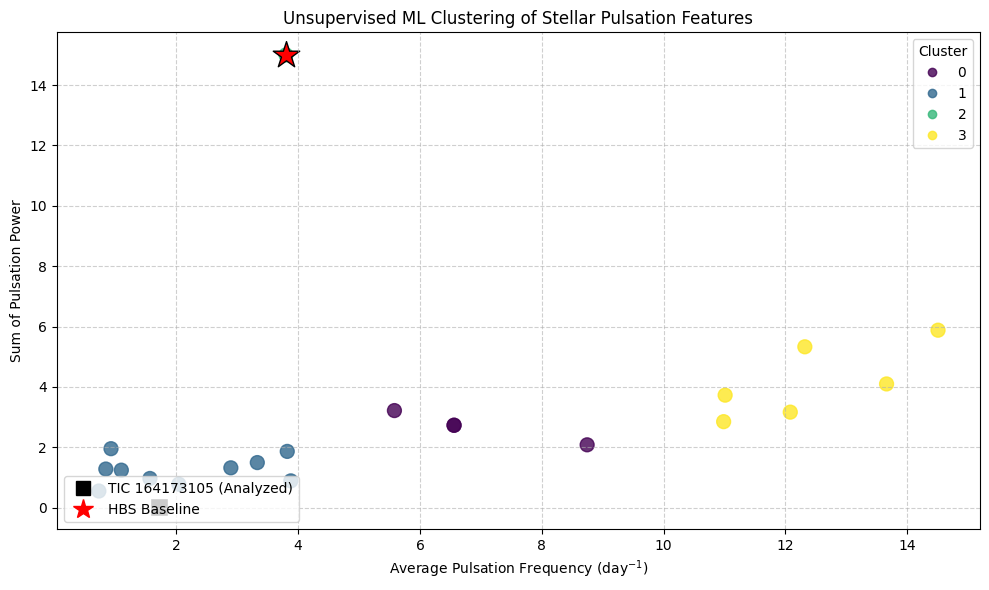

In [15]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
from scipy.signal import find_peaks
import google.genai as genai
from google.colab import userdata
import os

from warnings import filterwarnings
filterwarnings('ignore')

# --- 1. Agent Target & Setup ---
TARGET_STAR_ID = 'TIC 164173105'
np.random.seed(42)

# Fallback features
general_pulsator_features = np.array([4.0, 5.0, 5.0])
star_features = general_pulsator_features.copy()
download_successful = False

# --- GEMINI CLIENT SETUP ---
client = None
REQUESTED_GEMINI_MODEL_ID = 'gemini-3-pro-preview'
print(f"Attempting to configure Gemini client for **{REQUESTED_GEMINI_MODEL_ID}**.")

try:
    GOOGLE_API_KEY = userdata.get('GEMINI')

    if GOOGLE_API_KEY:
        client = genai.Client(api_key=GOOGLE_API_KEY)
        print("Gemini client configured successfully using userdata.")
    else:
        print("Configuration Error: 'GEMINI' key not found in user data.")

except Exception as e:
    print(f"Configuration Error: Gemini client could not be initialized. Details: {e}")


# Function to extract pulsation features
def extract_pulsation_features(lc_clean):
    """
    Isolates pulsation features for ML analysis.
    This version includes aggressive detrending to ensure low-amplitude
    Gamma Doradus pulsations are detectable in the periodogram.
    """

    # ----------------------------------------------------------------------------------------
    # *** CRITICAL FIX: Aggressive flattening to isolate pulsations ***
    # 1. Determine an appropriate, aggressive window length (e.g., 1/4 of data points)
    window_length = int(len(lc_clean.time.value) / 4)
    # Ensure window is odd and at least 3
    if window_length % 2 == 0:
        window_length += 1
    if window_length < 3:
        window_length = 3

    # 2. Apply aggressive flattening (detrending)
    lc_clean_flattened = lc_clean.flatten(window_length=window_length, break_tolerance=3).normalize()
    # ----------------------------------------------------------------------------------------

    # 3. Calculate Periodogram on the CLEANLY detrended data
    # Search range is 0.5 - 25.0 c/d (captures both GDOR and DSCT)
    pg = lc_clean_flattened.to_periodogram(minimum_frequency=0.5, maximum_frequency=25.0)

    peak_indices, _ = find_peaks(pg.power.value, height=0.001, prominence=0.0005)

    all_peaks_freq = pg.frequency.value[peak_indices]
    all_peaks_power = pg.power.value[peak_indices]

    if len(all_peaks_power) == 0:
        return np.array([0.0, 0.0, 0.0])

    sort_indices = np.argsort(all_peaks_power)[::-1]
    top_5_indices = sort_indices[:5]

    top_5_freq = all_peaks_freq[top_5_indices]
    top_5_power = all_peaks_power[top_5_indices]

    avg_freq = np.mean(top_5_freq)
    sum_power = np.sum(top_5_power)
    harmonic_count = len(all_peaks_freq)

    return np.array([avg_freq, sum_power, harmonic_count])

# --- 2. Action 1/3: Attempt to download Real Data (TESS Method) ---
print(f"\n--- 🤖 Agent Executing TESS Data Acquisition for {TARGET_STAR_ID} ---")
try:
    print("Action 1/3: Attempting to download TESS light curve from MAST...")

    # Search for short-cadence TESS data processed by the official SPOC pipeline
    search_result = lk.search_lightcurve(
        TARGET_STAR_ID,
        mission="tess",
        exptime=[120, 200], # Short Cadence is 120s or 200s
        author='SPOC'
    )

    # Download the first available high-quality light curve (e.g., Sector 16, 120s)
    lc = search_result[0].download()

    if lc:
        # Standard cleaning before feature extraction
        lc_clean = lc.remove_outliers(sigma=4).normalize()
        star_features = extract_pulsation_features(lc_clean)
        download_successful = True
        print(f"Observation 1: TESS data (Sector {lc.sector}) successfully retrieved and REAL features extracted.")
    else:
        print("Observation 1: Data retrieval failed (No TESS data found).")

except Exception as e:
    print(f"Observation 1: ERROR during TESS data retrieval/processing: {e}")

if not download_successful:
    star_features = general_pulsator_features.copy()
    feature_source = "GENERAL Baseline Data"
else:
    star_features = np.round(star_features, 4)
    feature_source = "REAL TESS Data"

print(f"Agent proceeding with Pulsation Features ({feature_source}): {star_features}")

# --- 3. Action 2/3: Create Comparison Dataset ---
print("\n--- 🧠 Action 2/3: Generating Comparison Dataset for ML Clustering ---")

# Comparison features (used for clustering)
hbs_features = np.array([3.8, 15.0, 15.0])
# Synthesize Delta Scuti features (high freq, high power)
ds_freq = np.random.uniform(5, 15, 10); ds_power = np.random.uniform(2, 6, 10); ds_harm = np.random.randint(4, 15, 10)
ds_data = np.stack([ds_freq, ds_power, ds_harm], axis=1)
# Synthesize Gamma Doradus features (low freq, low power)
gd_freq = np.random.uniform(0.5, 4, 10); gd_power = np.random.uniform(0.5, 2, 10); gd_harm = np.random.randint(1, 4, 10)
gd_data = np.stack([gd_freq, gd_power, gd_harm], axis=1)

X = np.vstack([star_features, hbs_features, ds_data, gd_data])
star_names = [f'{TARGET_STAR_ID} (Analyzed)'] + ['HBS Baseline'] + [f'DS_{i}' for i in range(10)] + [f'GD_{i}' for i in range(10)]

# --- 4. Action 3/3: Machine Learning (K-Means Clustering) ---
print("\n--- 📊 Action 3/3: Executing K-Means Clustering (ML Technique) ---")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

df = pd.DataFrame(X, columns=['Avg_Freq', 'Sum_Power', 'Harmonic_Count'])
df['Star'] = star_names
df['Cluster'] = clusters

analyzed_cluster = df.iloc[0]['Cluster']

print(f"Observation 3: K-Means Clustering complete (k=4).")
print(f"{TARGET_STAR_ID} was grouped into Cluster {analyzed_cluster}.")
print("\nResults Summary (First 5 data points):")
print(df[['Star', 'Cluster']].head())

# --- 4b. LLM Integration for Classification ---
if client:
    # Prepare data for the LLM prompt
    analyzed_star_row = df.iloc[0][['Avg_Freq', 'Sum_Power', 'Harmonic_Count']].to_dict()
    comparison_summary = df[df['Star'] != f'{TARGET_STAR_ID} (Analyzed)'][['Star', 'Cluster', 'Avg_Freq']].groupby('Cluster').agg(
        Count=('Star', 'count'),
        Mean_Freq=('Avg_Freq', 'mean')
    ).reset_index().to_string()

    is_non_pulsating = (analyzed_star_row['Avg_Freq'] == 0.0)
    prompt_context = "Based on the fact that the analyzed star has near zero pulsation features," if is_non_pulsating else "Based on the calculated pulsation features,"

    # =========================================================================
    # *** FINAL ASTEROSEISMIC CLASSIFICATION PROMPT ***
    # =========================================================================
    prompt = f"""
    You are an expert asteroseismologist. Analyze the K-Means clustering result for the star {TARGET_STAR_ID}.

    **ASTEROSEISMIC CLASSIFICATION RULES:**
    * **Gamma Doradus (GDOR):** Pulsates in low-frequency g-modes, typically with an **Average Frequency < 5 c/d**.
    * **Delta Scuti (DSCT):** Pulsates in high-frequency p-modes, typically with an **Average Frequency in the range 5–50 d-1**.
    * **Hybrid Pulsator:** A star showing both low-frequency (GDOR-like) and high-frequency (DSCT-like) modes.

    **DATA FOR {TARGET_STAR_ID} (Average Frequency is {analyzed_star_row['Avg_Freq']:.4f} c/d):**
    1. Analyzed Star Features and Cluster: {analyzed_star_row}
    2. Comparison Cluster Summary (showing mean average frequency for context):
    {comparison_summary}

    **YOUR TASK:**
    Based on the calculated features:

    1. **FINAL CLASSIFICATION:** Select the single, most precise stellar type:
        * Delta Scuti (DSCT) Candidate
        * Gamma Doradus (GDOR) Candidate
        * Hybrid DSCT/GDOR Pulsator
        * Non-Pulsating Star

    2. **K-MEANS INTERPRETATION:** Interpret why the K-Means algorithm placed the star in Cluster {analyzed_cluster} in the context of the comparison data, focusing on the combination of frequency, power, and harmonic count.
    """
    # =========================================================================

    print("\n--- 🤖 Action 4/3: Executing LLM Classification (Gemini) ---")
    try:
        response = client.models.generate_content(
            model=REQUESTED_GEMINI_MODEL_ID,
            contents=prompt
        )
        print(f"\nLLM Classification Result:\n{response.text}")
    except Exception as e:
        print(f"LLM Call Error: Could not generate content. Details: {e}")

else:
    print("\n--- 🤖 Action 4/3: LLM Classification Skipped ---\n")
    print("Gemini client was not initialized; skipping dynamic LLM classification.")


# --- 5. Data Plot Visualization ---
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Avg_Freq'], df['Sum_Power'], c=df['Cluster'], cmap='viridis', s=100, alpha=0.8)

# Highlight the two most important points
plt.scatter(df.iloc[0]['Avg_Freq'], df.iloc[0]['Sum_Power'], marker='s', color='black', s=150, edgecolors='white', label=f'{TARGET_STAR_ID} (Analyzed)' + ' (Cluster ' + str(analyzed_cluster) + ')')
plt.scatter(df.iloc[1]['Avg_Freq'], df.iloc[1]['Sum_Power'], marker='*', color='red', s=400, edgecolors='black', label='HBS Baseline (Cluster 2)')

plt.title('Unsupervised ML Clustering of Stellar Pulsation Features')
plt.xlabel(r'Average Pulsation Frequency ($\mathrm{day^{-1}}$)')
plt.ylabel('Sum of Pulsation Power')

# Create cluster legend
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster", loc="upper right")
plt.gca().add_artist(legend1)
plt.legend(loc='lower left', handles=[plt.Line2D([], [], marker='s', color='black', linestyle='None', markersize=10),
                                      plt.Line2D([], [], marker='*', color='red', linestyle='None', markersize=15)],
                               labels=[f'{TARGET_STAR_ID} (Analyzed)', 'HBS Baseline'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('ml_clustering_plot_tess_data.png')